<a href="https://www.goes-r.gov/">
<img src='./GOES-R_logo_small.png' style="height:150px" align=right alt="GOES16 Logo">
</a>

# GOES-16: Day Land Cloud Fire
__Brian Blaylock__   
__March 13, 2019__  
| brian.blaylock@utah.edu | [website](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html) |  

|Additional Notebooks |
|--|
|[GOES16 TrueColor](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_TrueColor.ipynb)|
|[GOES16 Day Convection](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_DayConvection.ipynb)|
|[GOES16 Air Mass](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_AirMass.ipynb)|
|[GOES16 Day Cloud Phase Distinction](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_DayCloudPhaseDistinction.ipynb)|
|[GOES16 Water Vapor](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_WaterVapor.ipynb)|
|[GOES16 Fire Temperature](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_FireTemperature.ipynb)|


This Python 3 notebook shows how to make the fire temperature product from the GOES-16 Advanced Baseline Imager (ABI) level 2 data. We will plot the image with `matplotlib` and `Basemap`. The image can be displayed on any map projection after applying a transformation using `pyproj`. The methods shown here are stitched together from the following useful information found online:
- [**Day Land Cloud Fire RGB Recipe**](http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_DayLandCloudFireRGB_final.pdf)
- [ABI Bands Quick Information Guides](https://www.goes-r.gov/education/ABI-bands-quick-info.html)
- [Open Commons Consortium](http://edc.occ-data.org/goes16/python/)
- [GeoNetCast Blog](https://geonetcast.wordpress.com/2017/07/25/geonetclass-manipulating-goes-16-data-with-python-part-vi/)
- [Proj documentation](https://proj4.org/operations/projections/geos.html?highlight=geostationary)
- [Pyproj documentation](http://jswhit.github.io/pyproj/pyproj.Proj-class.html)

The **Day Land Cloud Fire Product** is an RGB composite of the following three channels:


|         _ | Wavelength   | Channel | Description |
|----------|:------------:|:-------:|:-----------:|
| **Red**  | 2.2 &#181;m  |    6    | Particle Size and hot spots |
| **Green**| 0.86 &#181;m |    3    | Vegetation|
| **Blue** | 0.64 &#181;m |    2    | Visible Red|

---

## Download a GOES-16 ABI file
For this demo, you will need GOES-16 ABI level 2 data. You can get GOES-16 files from NOAA's GOES archive on [Amazon S3](https://aws.amazon.com/public-datasets/goes/). I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0) to easily download files from the Amazon archive. For scripted or bulk downloads, you should use `rclone` or `AWS CLI`. You may also download files from the [Environmental Data Commons](http://edc.occ-data.org/goes16/getdata/) and [NOAA CLASS](https://www.avl.class.noaa.gov/saa/products/search?sub_id=0&datatype_family=GRABIPRD&submit.x=25&submit.y=9).

This example uses the **level 2 _multiband_ formatted file for the _CONUS_ domain** ([ABI-L2-MCMIPC](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0)). The multiband file is easiest to work with becuase it contains all 16 channels on the same 2 km grid. However, some channels have higher resolution. Plotting the full resolution images will take some additional work, not described here.

I previously downloaded the following file from Amazon Web Services. The date and time this file corresponds to is during the [Pole Creek fire](https://inciweb.nwcg.gov/incident/6199/) in Utah on 14 September 2018. 

    OR_ABI-L2-MCMIPC-M3_G16_s20182570022128_e20182570024501_c20182570025006.nc

>OR     - Indicates the system is operational  
 ABI    - Instrument type  
 L2     - Level 2 Data  
 MCMIP  - Multichannel Cloud and Moisture Imagery products  
 c      - CONUS file (created every 5 minutes).  
 M3     - Scan mode  
 G16    - GOES-16  
 s##### - Scan start: 4 digit year, 3 digit day of year (Julian day), hour, minute, second, tenth second  
 e##### - Scan end  
 c##### - File Creation  
 .nc    - NetCDF file extension  

More information about GOES-16 files can be found on [Amazon AWS](https://docs.opendata.aws/noaa-goes16/cics-readme.html).

## First, import the libraries we will use

In [1]:
%matplotlib inline

import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Open the GOES-16 NetCDF File
Using xarray, I assign the opened file to the variable C for the CONUS domain.

In [2]:
FILE = 'OR_ABI-L2-MCMIPC-M3_G16_s20182570022128_e20182570024501_c20182570025006.nc'

C = xarray.open_dataset(FILE)

## Date and Time Information
Each file represents the data collected during one scan sequence for the domain. There are several different time stamps in this file, which are also found in the file's name.

In [3]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : %s' % scan_start)
print('Scan midpoint : %s' % scan_mid)
print('Scan End      : %s' % scan_end)
print('File Created  : %s' % file_created)
print('Scan Duration : %.2f minutes' % ((scan_end-scan_start).seconds/60))

Scan Start    : 2018-09-14 00:22:12.800000
Scan midpoint : 2018-09-14 00:23:31.400000
Scan End      : 2018-09-14 00:24:50.100000
File Created  : 2018-09-14 00:25:00.600000
Scan Duration : 2.62 minutes


## Day Land Cloud Fire Recipe
Color images are a Red-Green-Blue (RGB) composite of three different channels. We will assign the following channels as our RGB values, according the the [GOES Quick Guide Reference](http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_DayLandCloudFireRGB_final.pdf):


|          -    | **RED**      | **GREEN**      | **BLUE**     |
|---------------|:------------:|:--------------:|:------------:|
| **Name**      | Cloud Particle Size | "Veggie" | Visible Red |
| **Wavelength**| 2.2 &#181;m | 0.86 &#181;m   | 0.64 &#181;m |
| **Channel**   |      6       |       3        |      2       |
| **Units**     | Reflectance | Reflectance | Reflectance |
| **Range of Values**| 0-1 | 0-1 | 0-1|
| **Gamma Correction**| none |none|none|

Since RGB values must be between 0 and 1, we normalize the Red channel between the recommended range of values. Also, the gammea correction is used to control the brightness of the image where `corrected_value = value^(1/gamma)`.

The multiband formatted file we loaded is convenient becuase all the GOES channels are in the same NetCDF file. Next, we will assign our variables R, G, and B as the data for each channel.

In [4]:
# Confirm that each band is the wavelength we are interested in
for band in [6, 3, 2]:
    print("%s is %.2f %s" % (C['band_wavelength_C%02d' % band].long_name,
                             C['band_wavelength_C%02d' % band][0],
                             C['band_wavelength_C%02d' % band].units))

ABI band 6 central wavelength is 2.25 um
ABI band 3 central wavelength is 0.87 um
ABI band 2 central wavelength is 0.64 um


In [6]:
# Load the three channels into appropriate R, G, and B variables
R = C['CMI_C06'].data
G = C['CMI_C03'].data
B = C['CMI_C02'].data

In [7]:
# Normalize each channel by the appropriate range of values  e.g. R = (R-minimum)/(maximum-minimum)
R = (R-0)/(1-0)
G = (G-0)/(1-0)
B = (B-0)/(1-0)

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# Apply the gamma correction to Red channel.
#   corrected_value = value^(1/gamma)
gamma = 1
R = np.power(R, 1/gamma)

# The final RGB array :)
RGB = np.dstack([R, G, B])

## Simple Image
Use `plt.imshow` to get a quick look at the channels and RGB composite we created.

First, we plot each channel individually. The deeper the color means the satellite is observing more light in that channel. You will notice the hot spot in the red channel in the middle of the western United States.

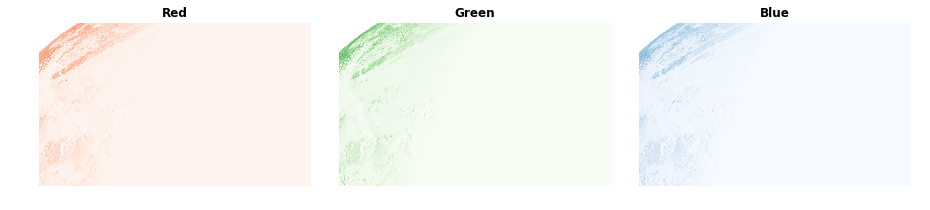

In [8]:
fig, ([ax1, ax2, ax3]) = plt.subplots(1, 3, figsize=(16,3))

ax1.imshow(R, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='semibold')
ax1.axis('off');

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('Green', fontweight='semibold')
ax2.axis('off');

ax3.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax3.set_title('Blue', fontweight='semibold')
ax3.axis('off');

plt.subplots_adjust(wspace=.02)

The addition of the three channels results in a color image. We combine the three channels in a stacked array and display the image with `imshow` again. Again, notice the hot spots in the west. Also notice that it is nighttime in the east.

(-0.5, 2499.5, 1499.5, -0.5)

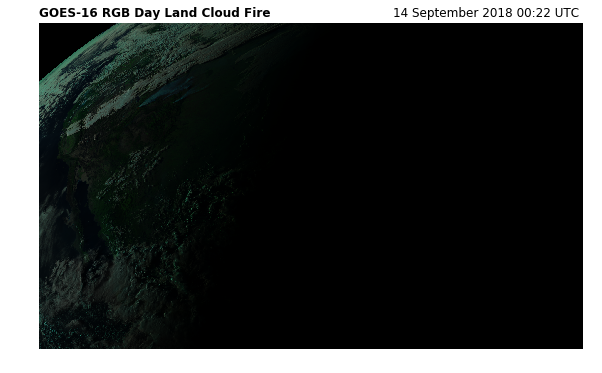

In [9]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))

# The RGB using the raw veggie band
ax1.imshow(RGB)
ax1.set_title('GOES-16 RGB Day Land Cloud Fire', fontweight='semibold', loc='left', fontsize=12);
ax1.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax1.axis('off')

## Plot with `Basemap`:  Geostationary Projection
The image above is not georeferenced. You can see the land and clouds, but we do have enough information to draw state and country boundaries. From the GOES-16 file, we can extract all the metadata needed to understand the map projection. We will use this data to plot the image on a `Basemap`. The image is in a [geostationary projection](https://proj4.org/operations/projections/geos.html?highlight=geostationary).

In [10]:
C['goes_imager_projection']

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647, dtype=int32)
Coordinates:
    t        datetime64[ns] 2018-09-14T00:23:31.484748032
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x

In [11]:
# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
# See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

The geostationary projection is the easiest way to plot the image on a map. Essentially, we are stretching the image across a map with the same projection and dimensions as the data.

In [12]:
m = Basemap(projection='geos', lon_0=sat_lon,
            resolution='i', area_thresh=5000,
            llcrnrx=x.min(),llcrnry=y.min(),
            urcrnrx=x.max(),urcrnry=y.max())

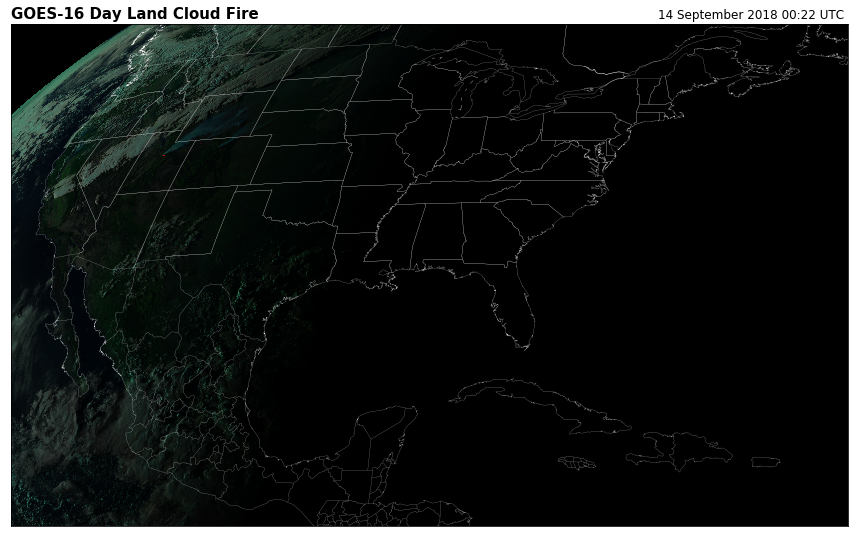

In [13]:
plt.figure(1, figsize=[15, 12])
m.imshow(np.flipud(RGB)) # Since "images" are upside down, we flip the RGB up/down
m.drawcoastlines(color='w', linewidth=.15)
m.drawcountries(color='w', linewidth=.15)
m.drawstates(color='w', linewidth=.15)

plt.title('GOES-16 Day Land Cloud Fire', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

---

## Using other projections

To apply a transformation of the image on other projections, we need to georeference each data point. We will use the metadata in the file and `pyproj` to calculate the latitude and longitude of each pixel so we can project the image onto other map projections. This is done by using an inverse transformation of the `pyproj.Proj` map projection object of the map coordinates given by X and Y. The image will then need to be plotted with `pcolormesh` becuase imshow can only plot rectangular images. Plotting an RGB with `pcolormesh` is not trivial, but the steps are described in this section.

#### The magic function: `pyproj.Proj`
This function creates a map projection object of the geostationary projection.

In [14]:
# Create a pyproj geostationary map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Perform cartographic transformation. That is, convert image projection coordinates (x and y)
# to latitude and longitude values.
XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

In the above image, you see a black area in the upper left corner where the value is `nan`. Since these pixels displaying outer space do not have coordinates on the globe, `pyproj.Proj` assigns these points a value 1e30. We will assign the latitude and longitude of these pixels as an arbitrary location in the Gulf of Alaska, a point that will not overlap the other data points. We do this becuase `pcolormesh` needs to know the latitude and longitude of every pixel and the x and y value cannot contain nans or masked values. Thus `pcolormesh` will stretch the black pixels in the corner of our GOES-16 image to converge on the coordinates 57 North and 152 West. The image will not display correctly without this step.

In [15]:
# Assign the pixels showing space as a single point in the Gulf of Alaska
lats[np.isnan(R)] = 57
lons[np.isnan(R)] = -152

 ## Plot with `Basemap`: Lambert Conformal Projection
 I am going to project the GOES-16 data on a Lambert Conformal Projection.

In [16]:
# Make a new map object Lambert Conformal projection
mL = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=3000*3000, height=2500*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

We can't simply plot the re-projected image with `imshow` because the pixels are spaced irregularly. We must use `pcolormesh`. Plotting RGB images with `pcolormesh` is not intuitive, but it possible. We need to create a flattened array of a color tuple for each pixel and assign it as the color. Details on doing this are on Stack Overflow [here](https://stackoverflow.com/questions/29232439/plotting-an-irregularly-spaced-rgb-image-in-python) and [here](https://stackoverflow.com/questions/41389335/how-to-plot-geolocated-rgb-data-faster-using-python-basemap). Below is my method.

In [17]:
# Create a color tuple for pcolormesh

# Don't use the last column of the RGB array or else the image will be scrambled!
# This is the strange nature of pcolormesh.
rgb = RGB[:,:-1,:]

# Flatten the array, becuase that's what pcolormesh wants.
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)

# Adding an alpha channel will plot faster, according to Stack Overflow. Not sure why.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

Now we can plot the GOES data on the new projection using pcolormesh

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


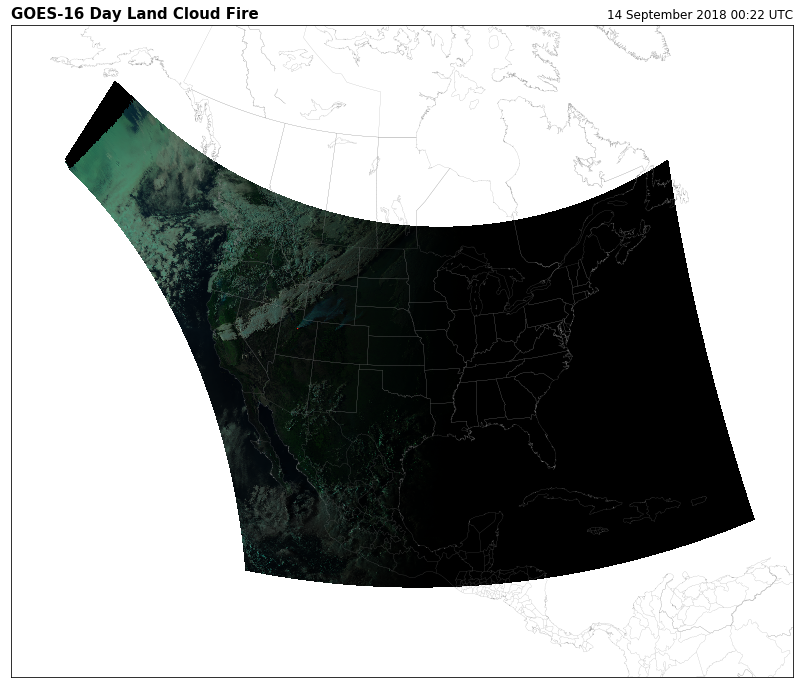

In [18]:
plt.figure(figsize=[15, 12])

# We need an array the shape of the data, so use R. The color of each pixel will be set by color=colorTuple.
newmap = mL.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # Without this line the RGB colorTuple is ignored and only R is plotted.

mL.drawcoastlines(color='grey', linewidth=.15)
mL.drawcountries(color='grey', linewidth=.15)
mL.drawstates(color='grey', linewidth=.15)

plt.title('GOES-16 Day Land Cloud Fire', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');

 ## Plot with `Basemap`: Cylindrical Projection
 It is often useful to zoom on a specific location. This image will zoom in on Utah.

In [19]:
# Location of Utah
l = {'latitude': 39.75,
     'longitude': -111.5}

# Draw zoomed map
mZ = Basemap(resolution='i', projection='cyl', area_thresh=50000,\
             llcrnrlon=l['longitude']-3.25, llcrnrlat=l['latitude']-3.25,\
             urcrnrlon=l['longitude']+3.25, urcrnrlat=l['latitude']+3.25,)

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


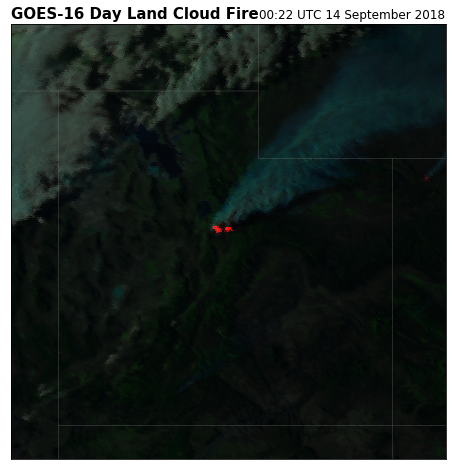

In [20]:
# Now we can plot the GOES data on a zoomed in map centered over Utah.
plt.figure(figsize=[8, 8])

newmap = mZ.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)

mZ.drawcoastlines(color='grey', linewidth=.15)
mZ.drawcountries(color='grey', linewidth=.15)
mZ.drawstates(color='grey', linewidth=.15)

plt.title('GOES-16 Day Land Cloud Fire', loc='left', fontweight='semibold', fontsize=15);
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');

# Compare Day Land Cloud Fire to True Color

First, get the True Color RGB, as described in the [GOES-16 True Color Tutorial](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_TrueColor.ipynb)

In [21]:
# Load the three channels into appropriate R, G, and B variables
TC_R = C['CMI_C02'].data
TC_G = C['CMI_C03'].data
TC_B = C['CMI_C01'].data

# Apply range limits for each channel. RGB values must be between 0 and 1
TC_R = np.clip(TC_R, 0, 1)
TC_G = np.clip(TC_G, 0, 1)
TC_B = np.clip(TC_B, 0, 1)

# Apply a gamma correction to the image
gamma = 2.2
TC_R = np.power(TC_R, 1/gamma)
TC_G = np.power(TC_G, 1/gamma)
TC_B = np.power(TC_B, 1/gamma)

# Calculate the "True" Green
TC_G_true = 0.45 * TC_R + 0.1 * TC_G + 0.45 * TC_B
TC_G_true = np.maximum(TC_G_true, 0)
TC_G_true = np.minimum(TC_G_true, 1)

# The RGB array for the true color image
TC_RGB = np.dstack([TC_R, TC_G_true, TC_B])

# Create a color tuple for pcolormesh

# Don't use the last column of the RGB array or else the image will be scrambled!
# This is the strange nature of pcolormesh.
TC_rgb = TC_RGB[:,:-1,:]

# Flatten the array, becuase that's what pcolormesh wants.
TC_colorTuple = TC_rgb.reshape((TC_rgb.shape[0] * TC_rgb.shape[1]), 3)

# Adding an alpha channel will plot faster, according to Stack Overflow. Not sure why.
TC_colorTuple = np.insert(TC_colorTuple, 3, 1.0, axis=1)

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


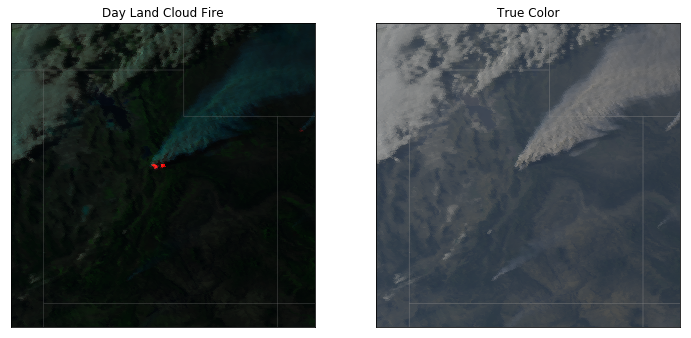

In [22]:
figb, [ax1b, ax2b] = plt.subplots(1, 2, figsize=(12,6))

plt.sca(ax1b)
newmap = mZ.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)

mZ.drawcoastlines(color='grey', linewidth=.15)
mZ.drawcountries(color='grey', linewidth=.15)
mZ.drawstates(color='grey', linewidth=.15)

plt.title('Day Land Cloud Fire');

plt.sca(ax2b)
newmap = mZ.pcolormesh(lons, lats, R, color=TC_colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)

mZ.drawcoastlines(color='grey', linewidth=.25)
mZ.drawcountries(color='grey', linewidth=.25)
mZ.drawstates(color='grey', linewidth=.25)

plt.title('True Color');